In [1]:
%matplotlib notebook 
from model.self_pose import SelfPose
from dataloader import XRegoDataset 
from torch.utils.data import DataLoader
import time
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import webdataset as wds
from torchvision import transforms
import glob
from webdataset.handlers import ignore_and_continue
from mpl_toolkits.mplot3d import axes3d 
import typing as tp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
preproc = transforms.Compose([
    transforms.Resize((368,368)),
    transforms.ToTensor(),
])

def transform(x):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,3)
    x = np.concatenate((x[6:7], x[2:5], x[14:17], x[22:25], x[5:6], x[29:32], x[35:38]))

    return x.reshape(-1)

def image_preproc(x):
    return preproc(x)



## Plot Kinematic Tree

In [3]:


def get_chain_dots(
        joints: np.ndarray,   # shape == (n_dots, 3)
        chain_dots_indexes: tp.List[int], # length == n_dots_in_chain
                                          # in continuous order, i.e. 
                                          # left_hand_ix >>> chest_ix >>> right_hand_ix
        ) -> np.ndarray:    # chain of dots
    return joints[chain_dots_indexes]


def get_chains(
        joints,   # shape == (n_dots, 3)
        head: tp.List[int], # pelvis >>> chest >>> head
        spine: tp.List[int], # left_leg >>> pelvis >>> right_leg
        arm1: tp.List[int],
        arm2,
        neck,
        right_leg,
        left_leg,
        ):
    return (get_chain_dots(joints, head),
            get_chain_dots(joints, spine),
            get_chain_dots(joints, arm1),
            get_chain_dots(joints, arm2),
            get_chain_dots(joints, neck),
            get_chain_dots(joints, right_leg),
            get_chain_dots(joints, left_leg),
            )


def subplot_nodes(dots: np.ndarray, # shape == (n_dots, 3)
                  ax):
    return ax.scatter3D(*dots.T, c=dots[:, -1])


def subplot_bones(chains: tp.Tuple[np.ndarray, ...], ax):
    return [ax.plot(*chain.T) for chain in chains]


def plot_skeletons(skeletons, chains_ixs):
    fig = plt.figure(figsize=(10, 5))
    for i, joints in enumerate(skeletons, start=1):
        chains = get_chains(joints, *chains_ixs)
        ax = fig.add_subplot(1, 2, i, projection='3d')
        subplot_nodes(joints, ax)
        subplot_bones(chains, ax)
    plt.show()
    
def plot(gt_pose, pred_pose):
    # Kinematic Tree for visualization
    # each list create bones between joints
    chains_ixs = ([0],[1, 2, 3],[3, 4, 5, 6],[3, 7, 8, 9],[3, 10],[1, 11,12,13],[1, 14,15,16]) 
    plot_skeletons([gt_pose, pred_pose], chains_ixs)
 
       


In [5]:
train_url = glob.glob("/egopose-data/web-datasets/xr*train*tar")
test_url = glob.glob("/egopose-data/web-datasets/xr*test*tar")

ds = wds.WebDataset(train_url).decode("pil").to_tuple("pose_image.png", "pose_image_depth.png", "pose_3dp.csv").map_tuple(image_preproc, image_preproc, transform)
train_loader = DataLoader(ds.batched(1), num_workers=1, batch_size=None)

ds_test = wds.WebDataset(test_url).shuffle(100, initial=100).decode("pil").to_tuple("pose_image.png", "pose_image_depth.png","pose_3dp.csv").map_tuple(image_preproc, image_preproc, transform)
test_loader = DataLoader(ds_test, num_workers=1, batch_size=32)
 
self_pose = SelfPose()
dataloaders = {"train": train_loader, "val": test_loader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
self_pose.load_state_dict(torch.load("./ckpts/57mm.pth"), strict=False)
self_pose.to(device)
print()

In [9]:
def calculate_error(pred, gt):
    pred = pred.reshape((-1, 6, 3))
    gt = gt.reshape((-1, 6, 3))
    error = np.sqrt(np.sum((pred-gt) ** 2, axis=2))
    return np.mean(error)

def inference(model):
    results = []
    model.eval()   # Set model to evaluate mode
    phase="val"
    errors = []
    for inputs, depth, labels in dataloaders["val"]: 
        inputs = inputs.to(device).float()
        depth =  depth.to(device).float()
        with torch.set_grad_enabled(phase == 'train'):
            outputs, _, _ = self_pose(inputs)
            outputs = outputs.view(-1, 6, 3).cpu().numpy() * 300 # both arms  
            labels = labels.reshape(-1, 17, 3).cpu().numpy() # 17 joints for visualizatoin
            err = calculate_error(outputs, labels[:, 4:10]) # 4-10 are both arm joints
            print("Batch Error:", err)
            yield outputs, labels, err
            

def plot_inference(model, plot_max=5):
    for i, (outputs, labels, error) in enumerate(inference(model)):
        pred = labels.copy()
        pred[:, 4:10] = outputs # replace orignal arm joints with predicted arm joints in kinematic tree
        plot(pred[0], labels[0]) #plot first prediction in batch
        if i >= plot_max:
            break
def mean_error(model, total_batches=float("inf")):
    errors = []
    for i, (_, _, error) in enumerate(inference(model)):
        errors.append(error)
        if i >= total_batches:
            break
            
    print(f"Mean Error of all batches: {np.mean(errors)*10} millimeters ")
        
        

mean_error(self_pose,10)

Batch Error: 2.7932085001713247
Batch Error: 2.7990479710813703
Batch Error: 2.4868691560258664
Batch Error: 2.5848530806291214
Batch Error: 2.2908123567327197
Batch Error: 2.298578381293419
Batch Error: 2.3220653062996415
Batch Error: 2.319313559435762
Batch Error: 2.4490151861167253
Batch Error: 2.4864639004453406
Batch Error: 3.0980222843817256
Mean Error of all batches: 25.389317893284556 millimeters 


Batch Error: 2.7932126362803946


<IPython.core.display.Javascript object>


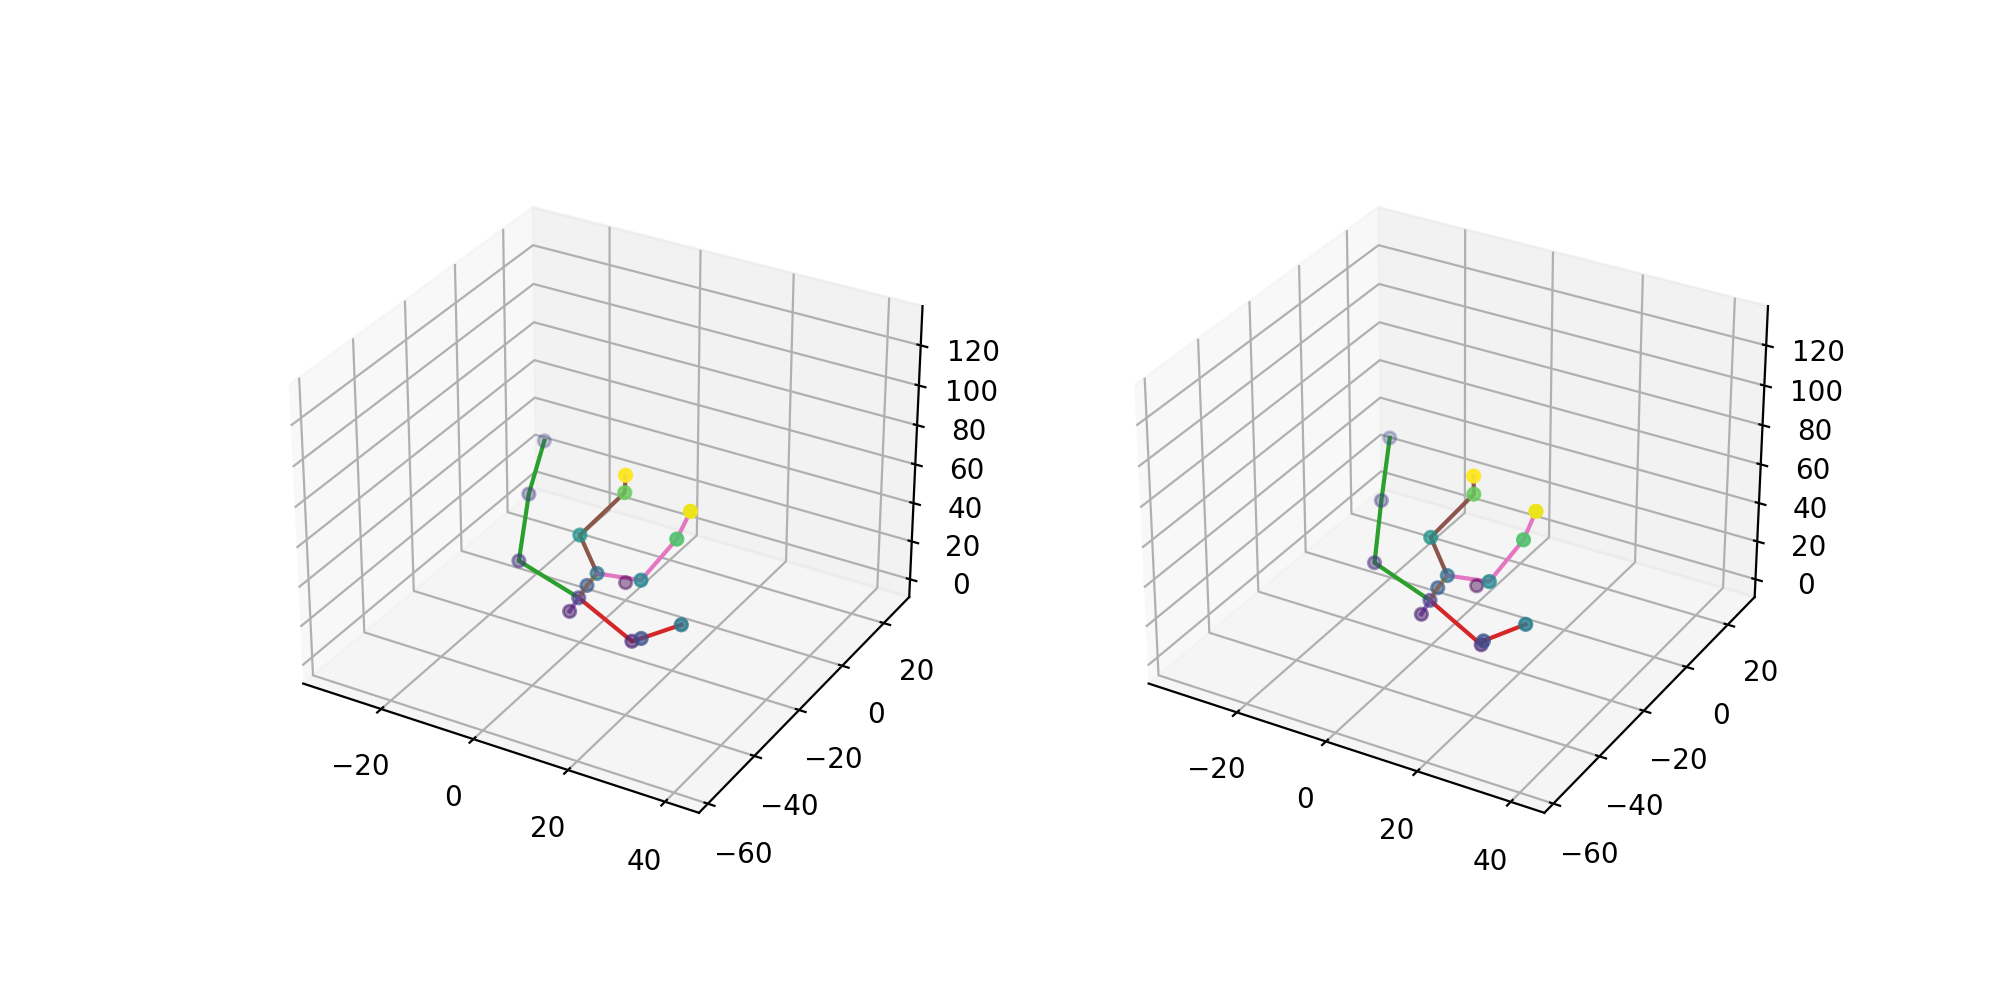

Batch Error: 2.7990492384669756


<IPython.core.display.Javascript object>


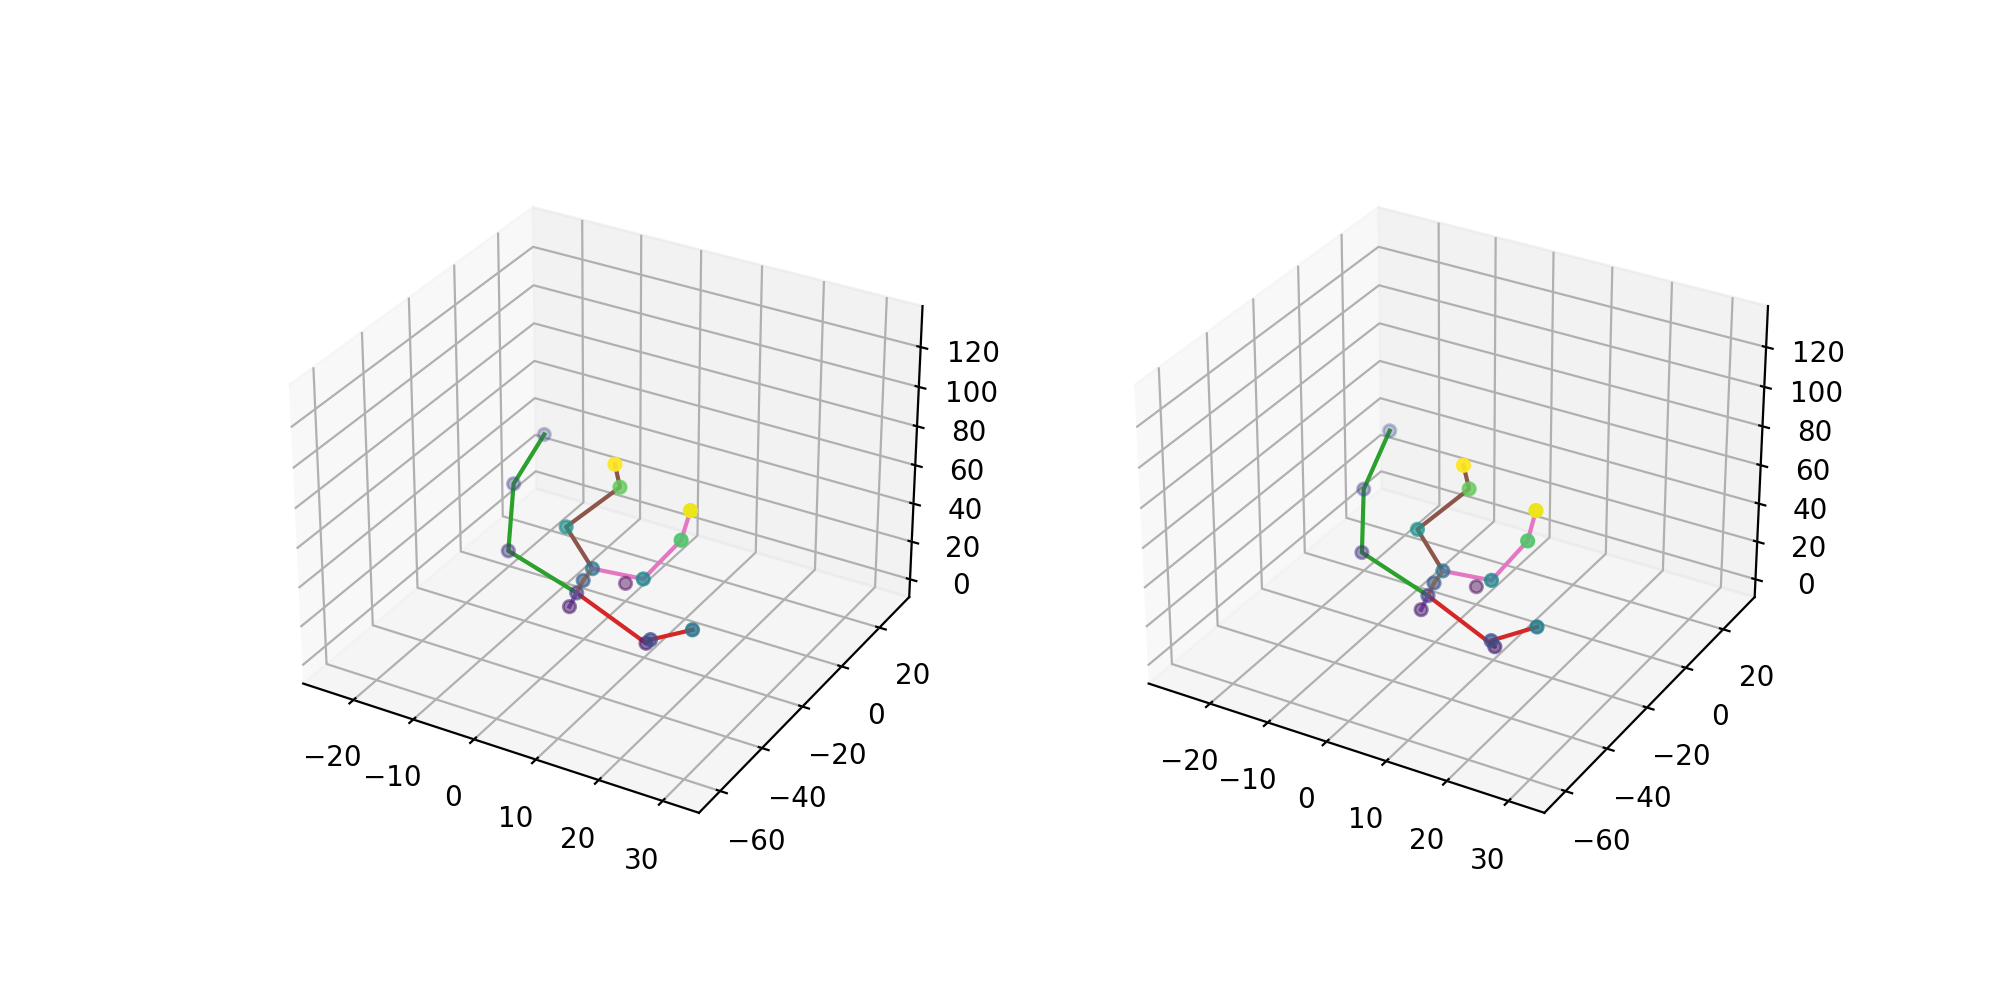

Batch Error: 2.486867119005916


<IPython.core.display.Javascript object>


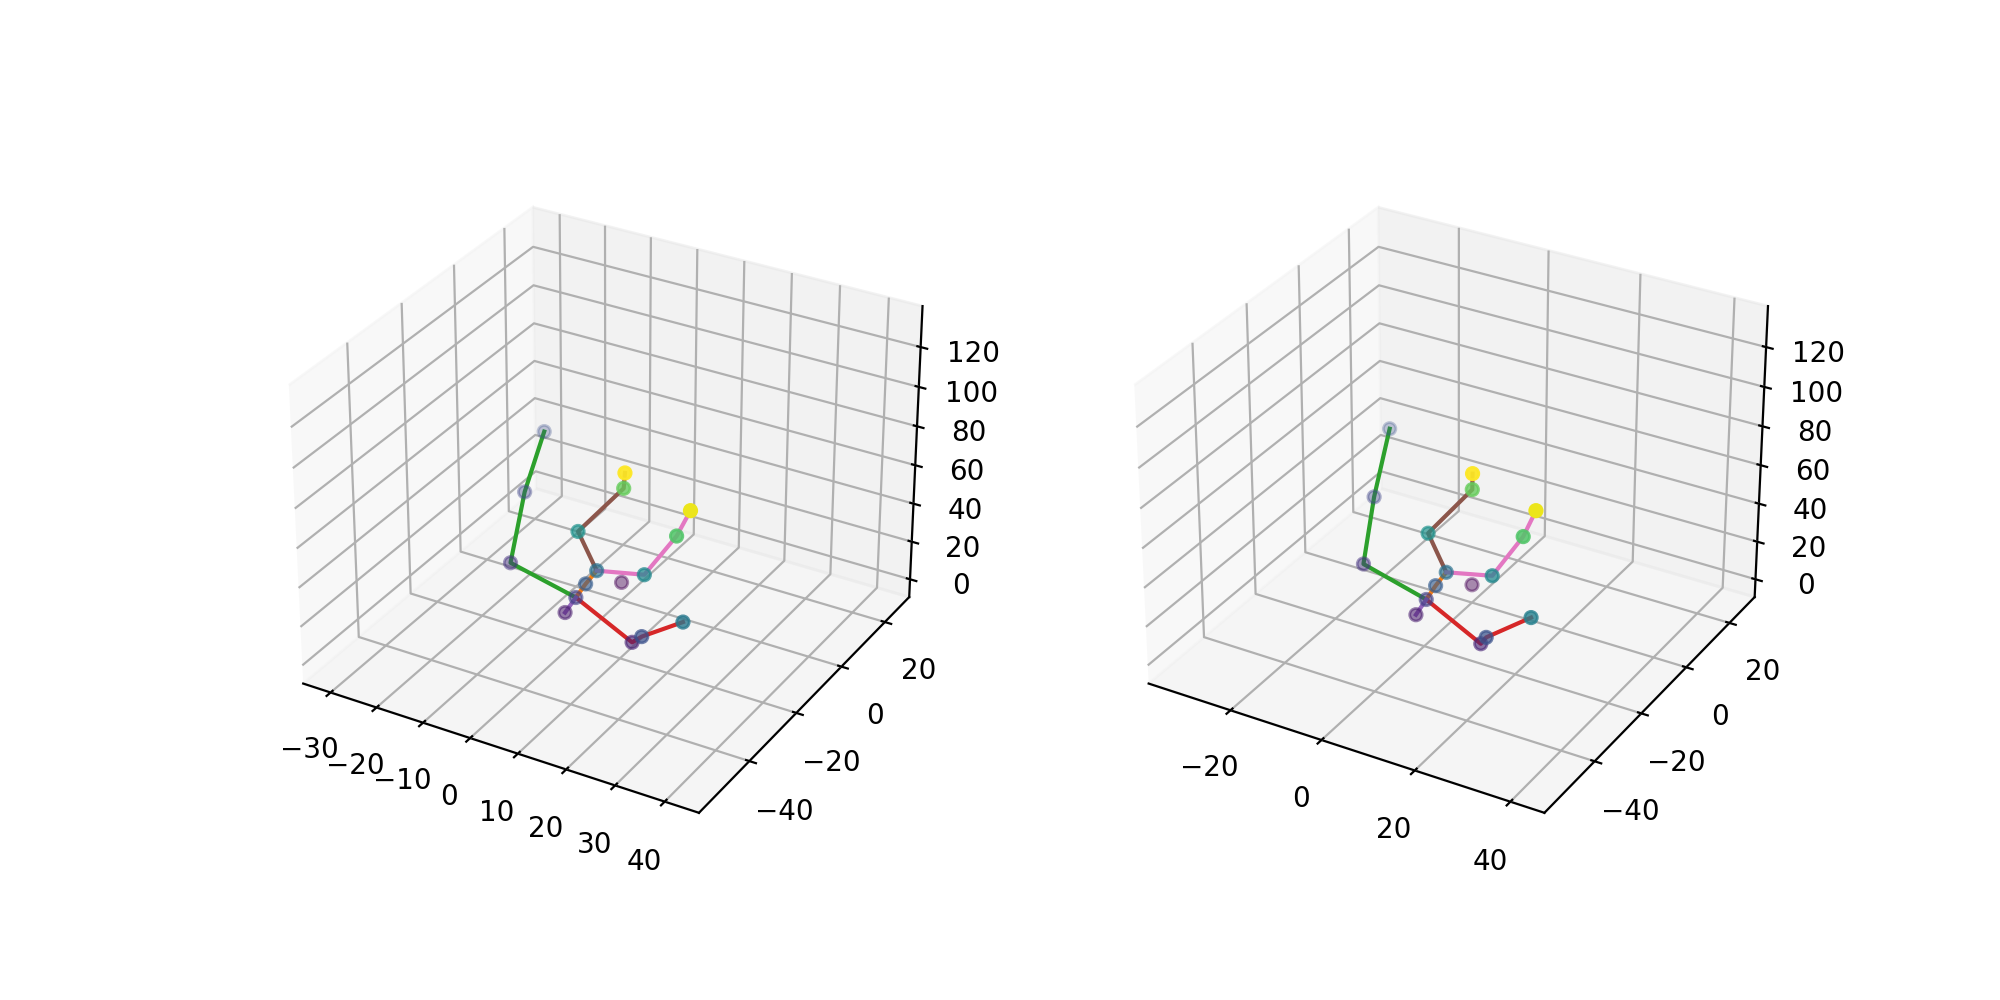

Batch Error: 2.58485275287758


<IPython.core.display.Javascript object>


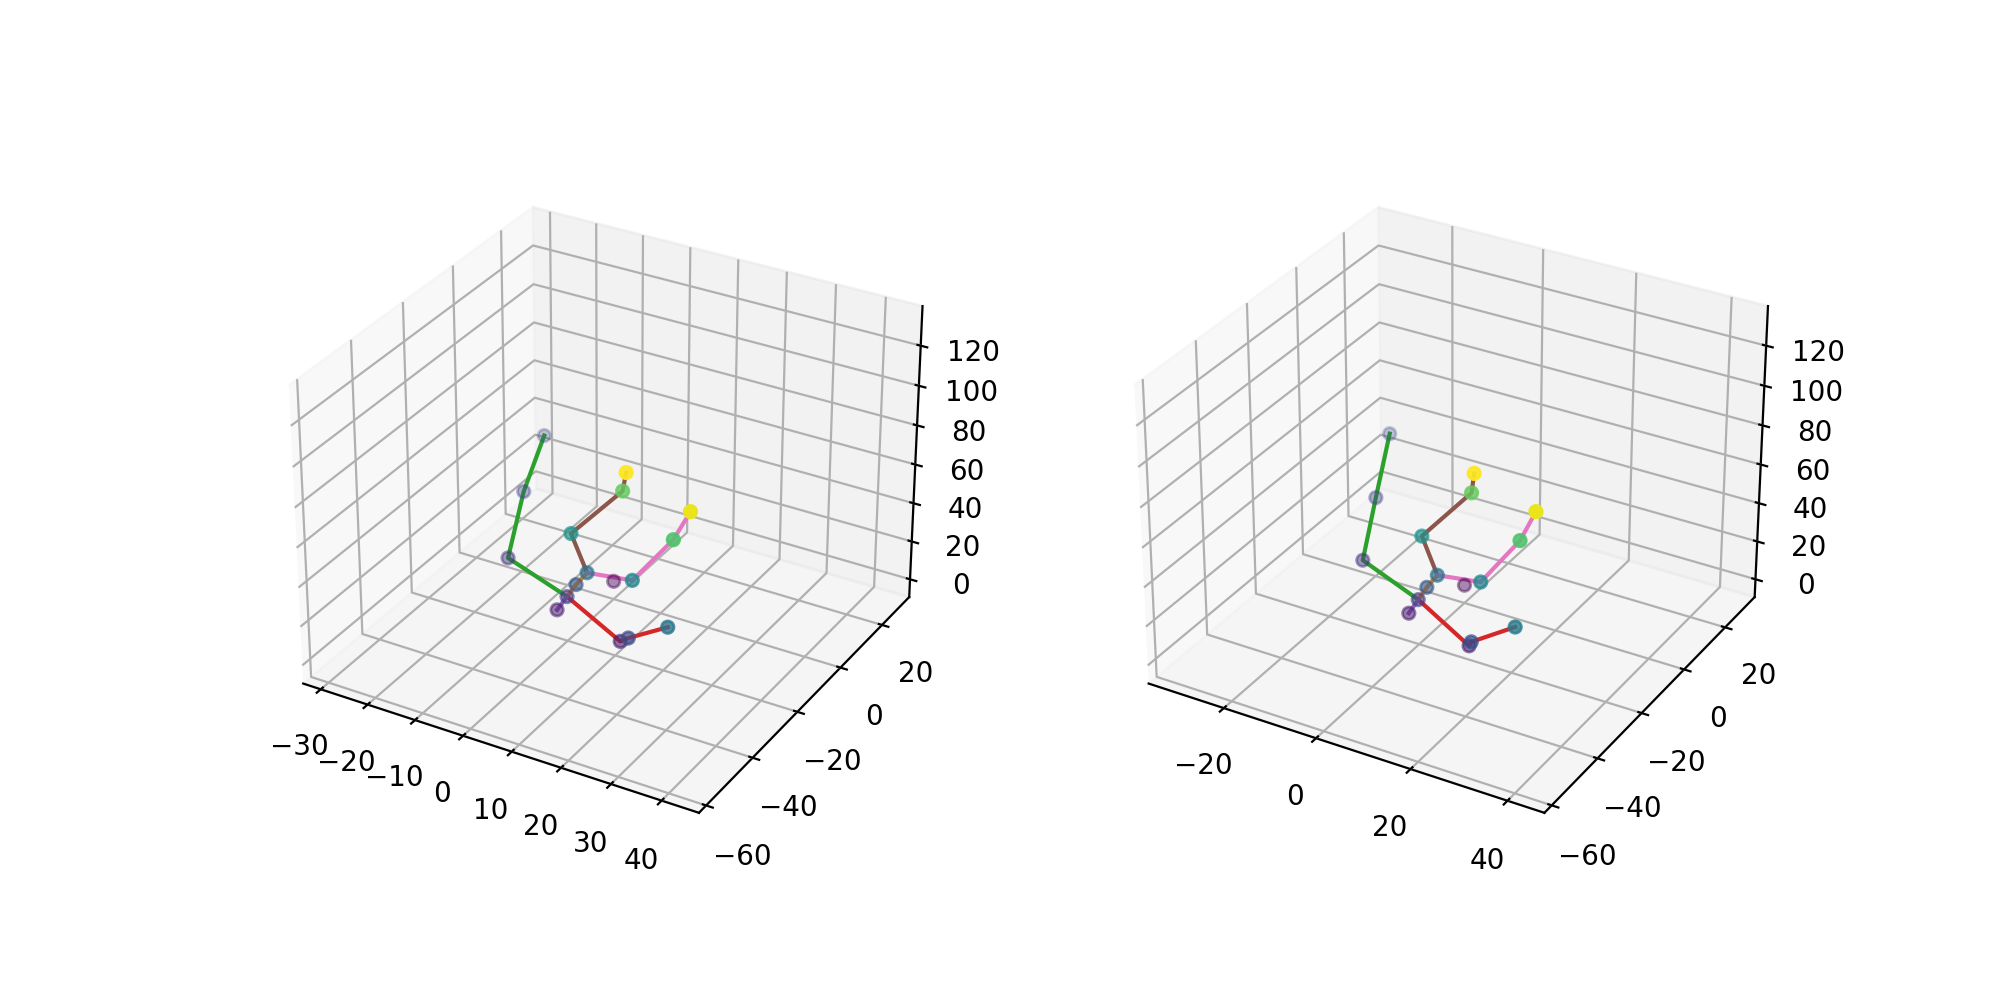

Batch Error: 2.290811277292155


<IPython.core.display.Javascript object>


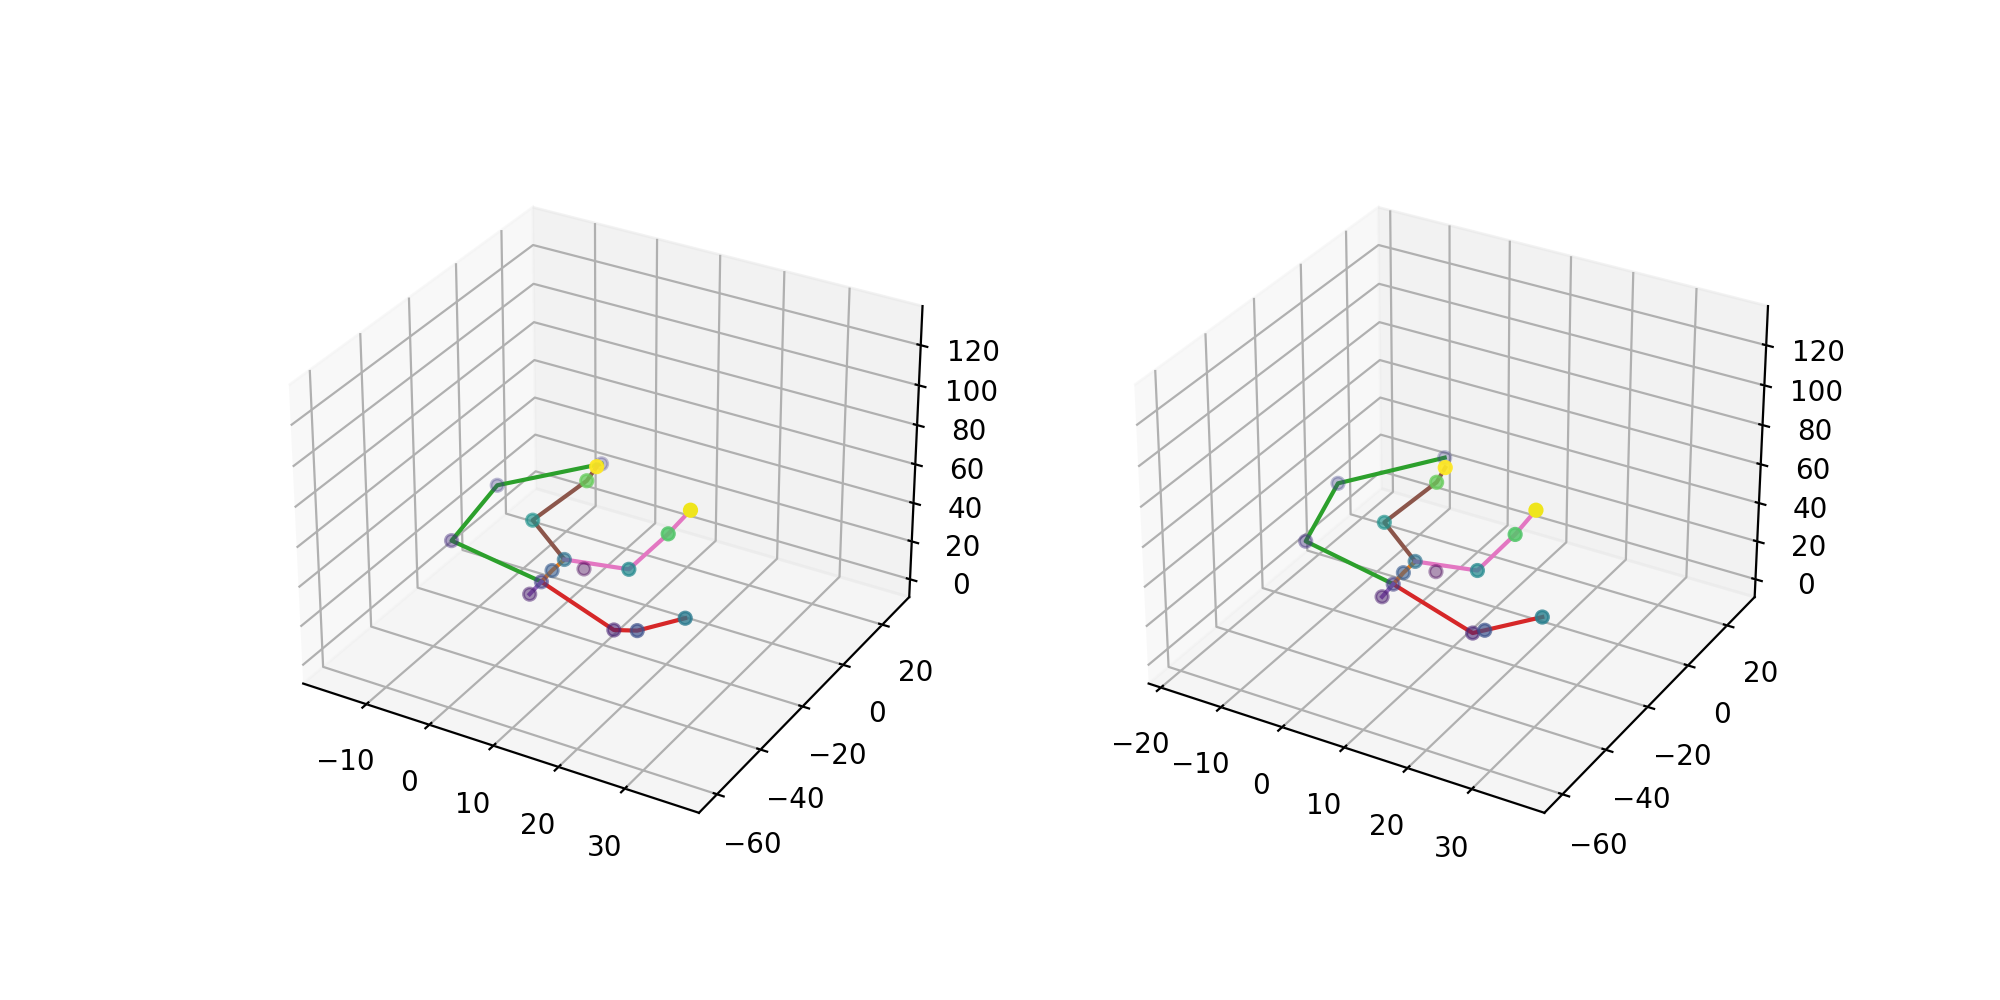

Batch Error: 2.298577975282482


<IPython.core.display.Javascript object>


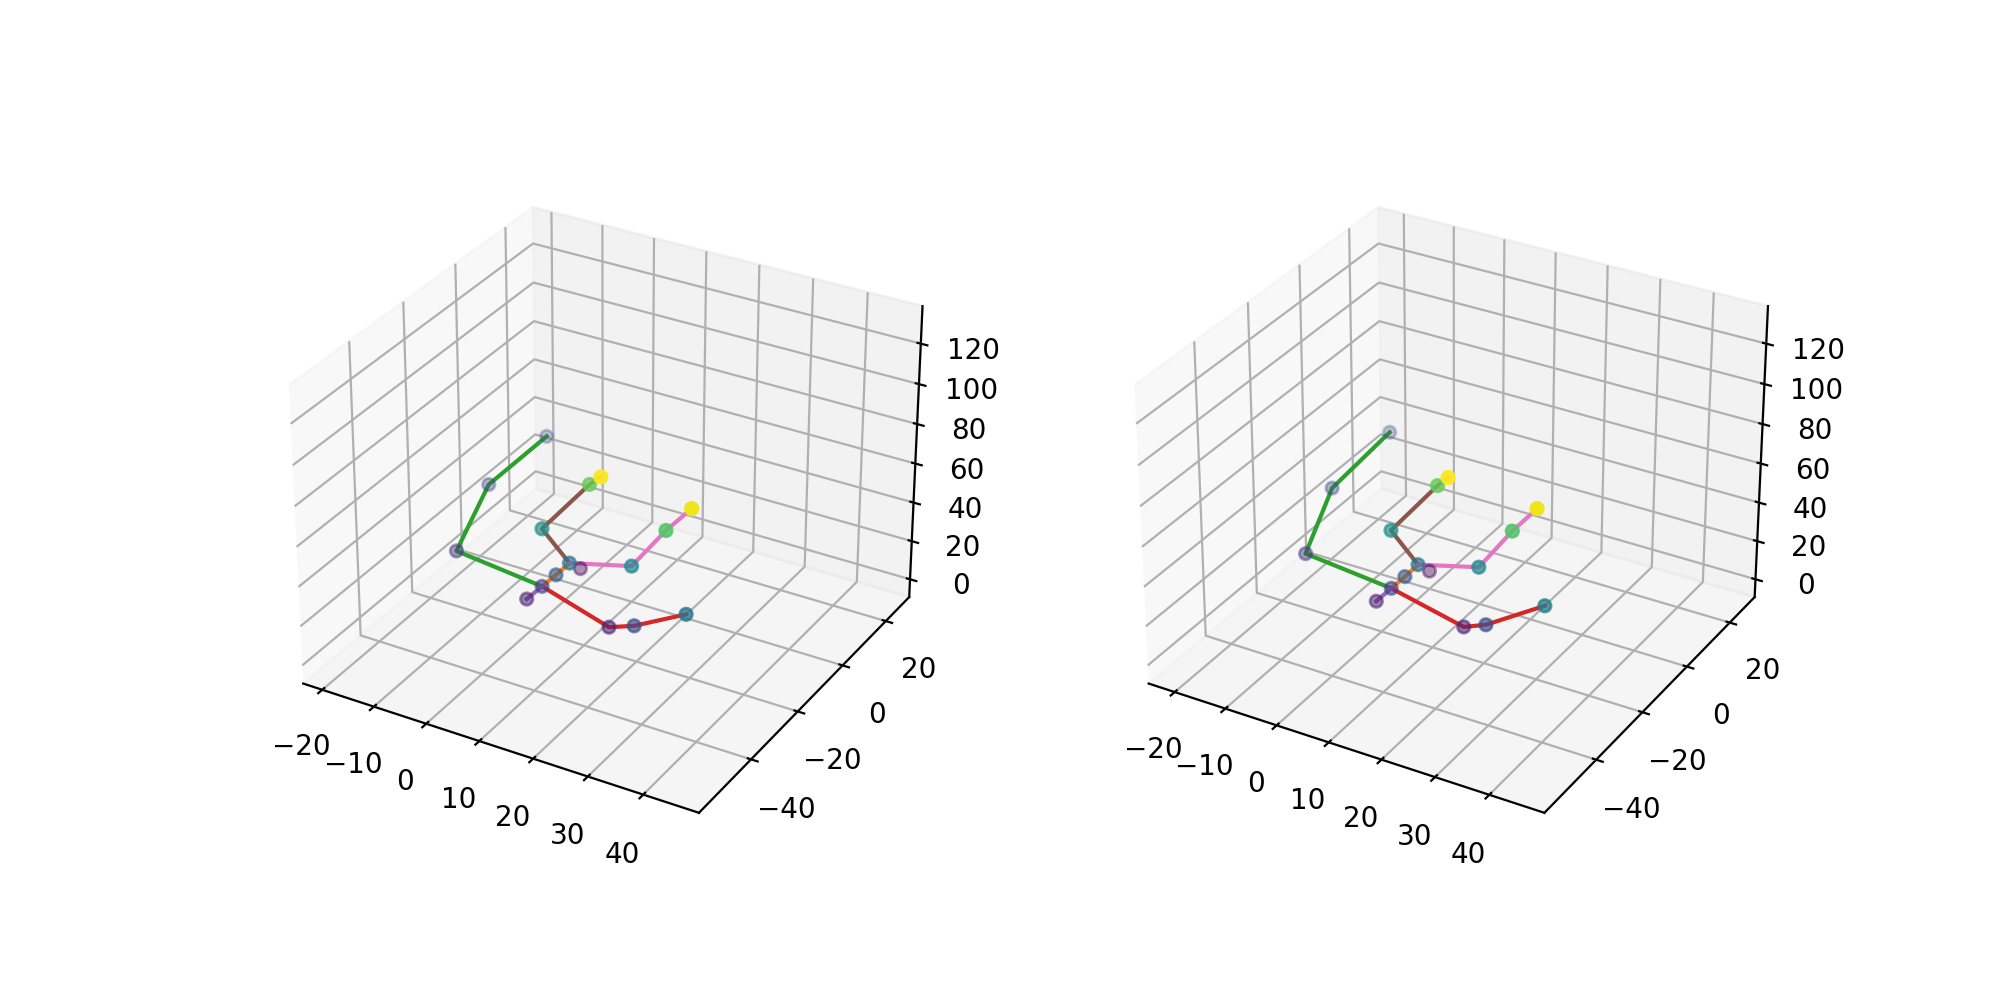

In [11]:
plot_inference(self_pose, 5)